# Identifying S Protein Mutation Hotspots

Objective: Determine how many times each position within the SARS-CoV-2 S protein was reported to have a non-synonymous mutation in the NIH SRA database.

## Basic Data Profiling

In [6]:
%%bigquery
SELECT COUNT(protein_name)
FROM `bigquery-public-data.nih_sequence_read.annotated_variations`
WHERE protein_name IS NULL;

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,0


In [1]:
%%bigquery
SELECT COUNT(DISTINCT protein_name) AS unique_prot_names
FROM `bigquery-public-data.nih_sequence_read.annotated_variations`;

Query is running:   0%|          |

Downloading:   0%|          |

,unique_prot_names
0,40


This is a low enough number of unique names for me to manually identify variations of "S protein".

In [2]:
%%bigquery
SELECT DISTINCT protein_name
FROM `bigquery-public-data.nih_sequence_read.annotated_variations`;

Query is running:   0%|          |

Downloading:   0%|          |

,protein_name
0,S
1,nsp3
2,3C-like_proteinase-gene
3,ORF3a protein
4,membrane glycoprotein
5,ORF3a
6,ORF10
7,ORF7a protein
8,endoRNAse
9,ORF7a


The only two variations are "S" and "surface glycoprotein".

## Analysis

Now, I can count the number of times a run reported a non-synonymous mutation for each position:

In [3]:
%%bigquery
SELECT protein_position, COUNT(protein_position)
FROM
( SELECT run, protein_position
FROM `bigquery-public-data.nih_sequence_read.annotated_variations`
WHERE (protein_name = "S" OR protein_name = "surface glycoprotein") AND (EFFECT = "NON_SYNONYMOUS_CODING")
GROUP BY run, protein_position
)
GROUP BY protein_position;

Query is running:   0%|          |

Downloading:   0%|          |

,protein_position,f0_
0,655,1444577
1,405,1413291
2,452,1862954
3,796,1378225
4,969,2299673
...,...,...
1267,1028,66
1268,650,22
1269,418,113
1270,901,66


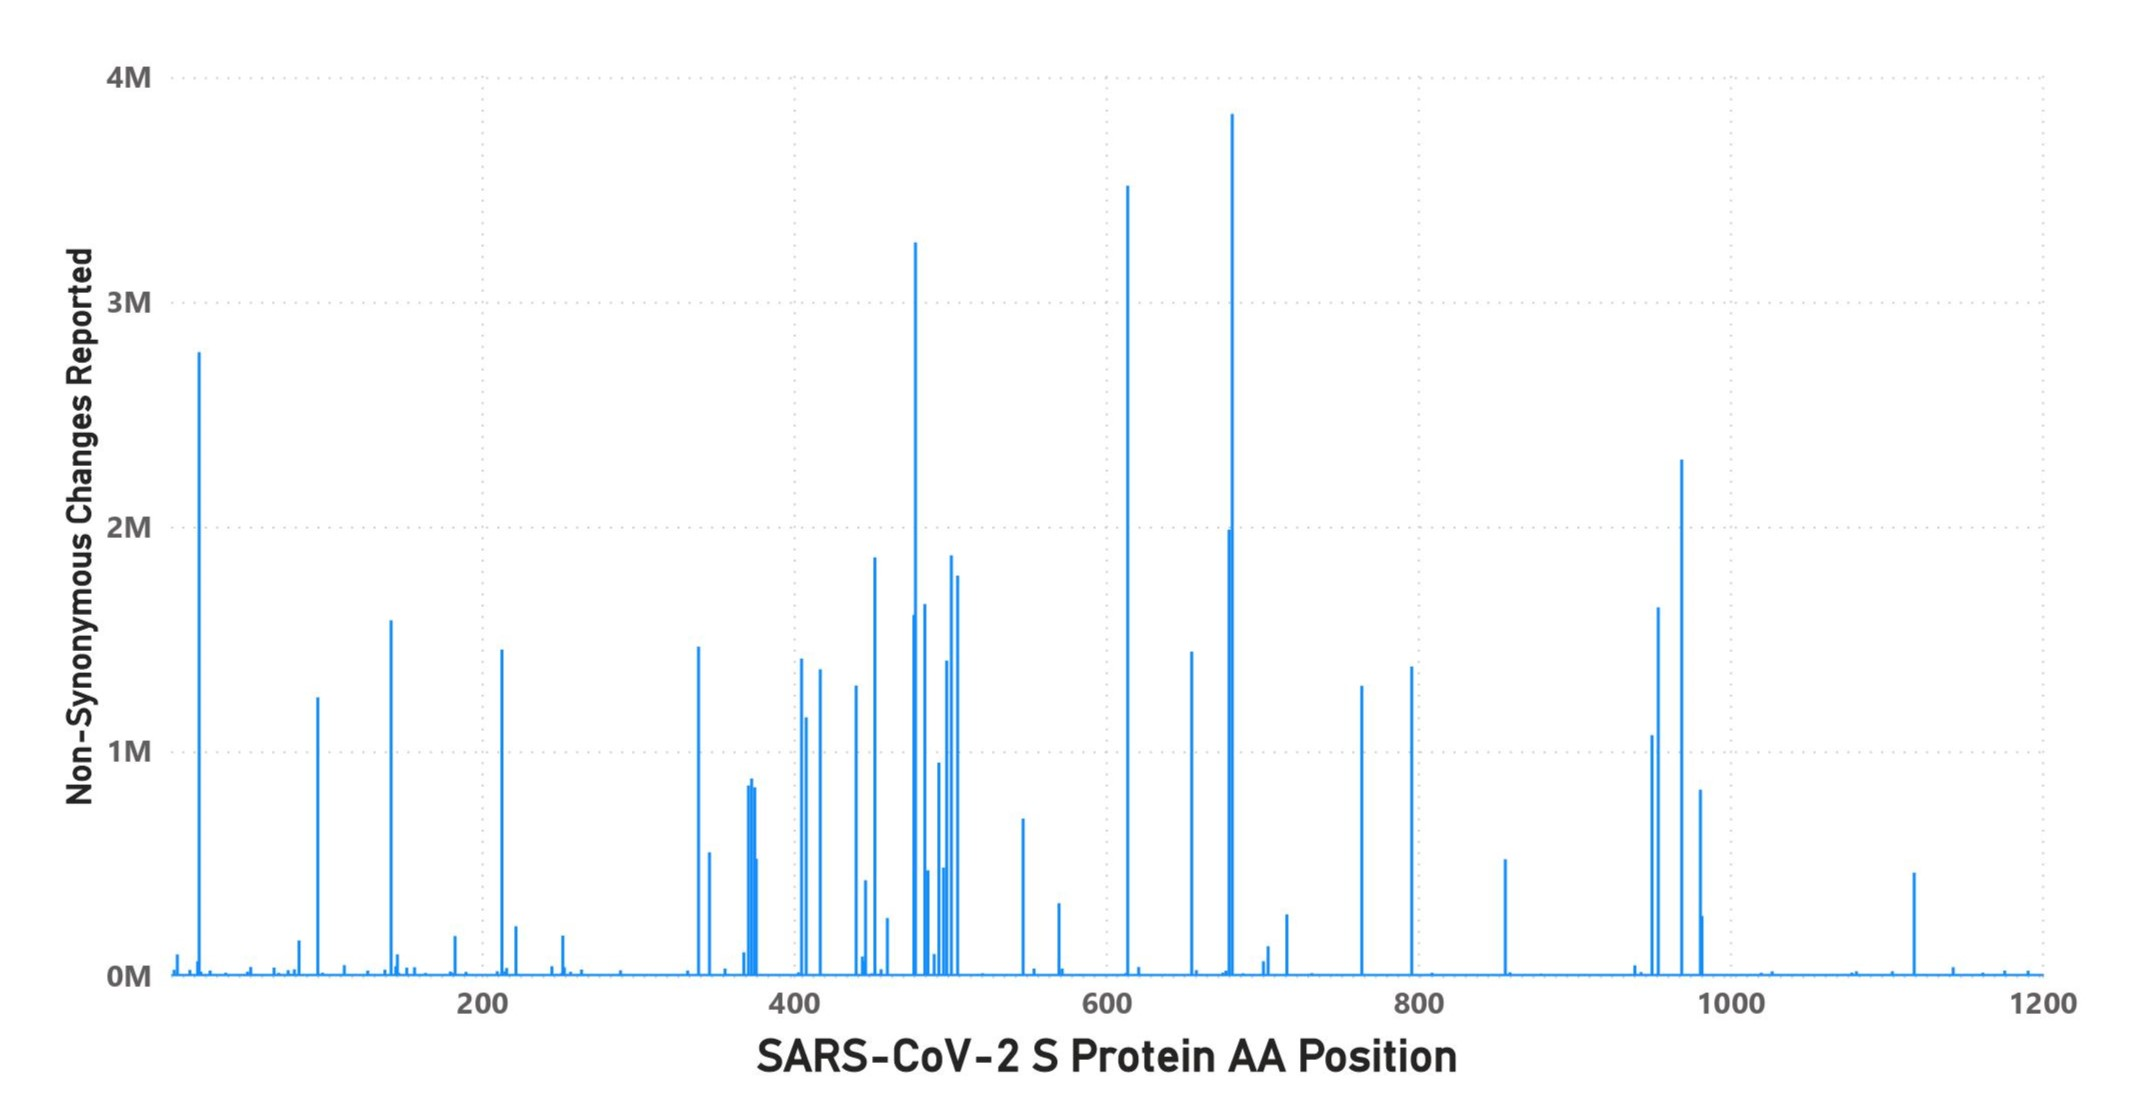

A quick review of the literature suggests this result is at least somewhat biologically informative. For example, the hCoV-19, Omicron, and Delta variants have different amino acids at position 681 (biggest spike in graph above), so it's not too suprising that variation at this site is reflected in the database.

# Strain Emergence

Objective: This analysis is more about the utility of the NIH's SARS-CoV-2 variant dataset more than anything biological. I wanted to illustrate the massive discrepancy in the predicted time of divergence when using the date of earliest observation compared to phylogenetic methods (as determined by Nextstrain).

## Basic Data Profiling

The NIH documentation says the date of collection (collection_date_sam) is stored as a string.

In [4]:
%%bigquery
SELECT COUNT(collection_date_sam)
FROM `nih-sra-datastore.sra.metadata`
WHERE collection_date_sam IS NULL;

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,0


## Analysis

A simple way to accomplish this is to  find the first time a mutation that Nextstrain classifies as "unique" to a given clade appears in the NIH dataset. The mutations included in the query below are considered to be unique to a clade that is estimated to have emerged in 2021.

To find the earliest records with these mutations:

In [ ]:
%%bigquery results
SELECT CAST(collection_date_sam AS datetime) AS collection_date
FROM `nih-sra-datastore.sra.metadata`
WHERE acc IN
( SELECT run
FROM `bigquery-public-data.nih_sequence_read.annotated_variations`
WHERE (variation = "S371F" OR variation = "S373P" OR variation = "S375F" OR variation = "N440K" OR variation = "E484A" OR variation = "Q498R" OR variation = "N679K" OR variation = "N764K" OR variation = "D796Y" OR variation = "Q954H" OR variation = "N969K")
)
ORDER BY collection_date ASC;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
results[results.collection_date.notnull()][:5]

,collection_date
9110,2000-01-01
9111,2002-11-03
9112,2007-10-02
9113,2008-08-23
9114,2009-09-23
